Problem 4
========

In [35]:
import torch
import torch.nn as nn
from torchinfo import summary
from torchviz import make_dot
from torch.utils.data import Dataset,DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import numpy as np

In [49]:
class STMConvLayer(nn.Module):
    def __init__(self):
        super(STMConvLayer, self).__init__()
        self.conv = nn.ModuleList()
        for _ in range(32):
            self.conv.append(
                nn.Sequential(
                    nn.Conv2d(256, 4, 1, dtype=torch.float),  # Specify dtype=torch.float
                    nn.ReLU(),
                    nn.Conv2d(4, 4, 3, padding=1, dtype=torch.float),  # Specify dtype=torch.float
                    nn.ReLU(),
                    nn.Conv2d(4, 256, 1, dtype=torch.float)  # Specify dtype=torch.float
                )
            )
    def forward(self,x): # x : bathced data
        output = torch.zeros(x.shape, dtype=torch.float)
        for path in self.conv:
            output += path(x.float())
        return output

In [52]:
d = 256
n_train = 100
dummy_data = np.random.randn(10, 256, 3, 3)  # 10 samples, 256 channels, 3x3 spatial dimensions

# Convert dummy data to PyTorch tensor
dummy_tensor = torch.tensor(dummy_data, dtype=torch.float)

# Create DataLoader with the dummy dataset
dummy_loader = DataLoader(dummy_tensor, batch_size=1)  # Batch size 1 as we're already providing batched data

batch = next(iter(dummy_loader))
model = STMConvLayer()
yhat = model(batch)
make_dot(yhat, params=dict(list(model.named_parameters()))).render("STMConvLayer", format="png")

'STMConvLayer.png'

In [59]:
print(model)

STMConvLayer(
  (conv): ModuleList(
    (0-31): 32 x Sequential(
      (0): Conv2d(256, 4, kernel_size=(1, 1), stride=(1, 1))
      (1): ReLU()
      (2): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU()
      (4): Conv2d(4, 256, kernel_size=(1, 1), stride=(1, 1))
    )
  )
)


Problem 5
=====

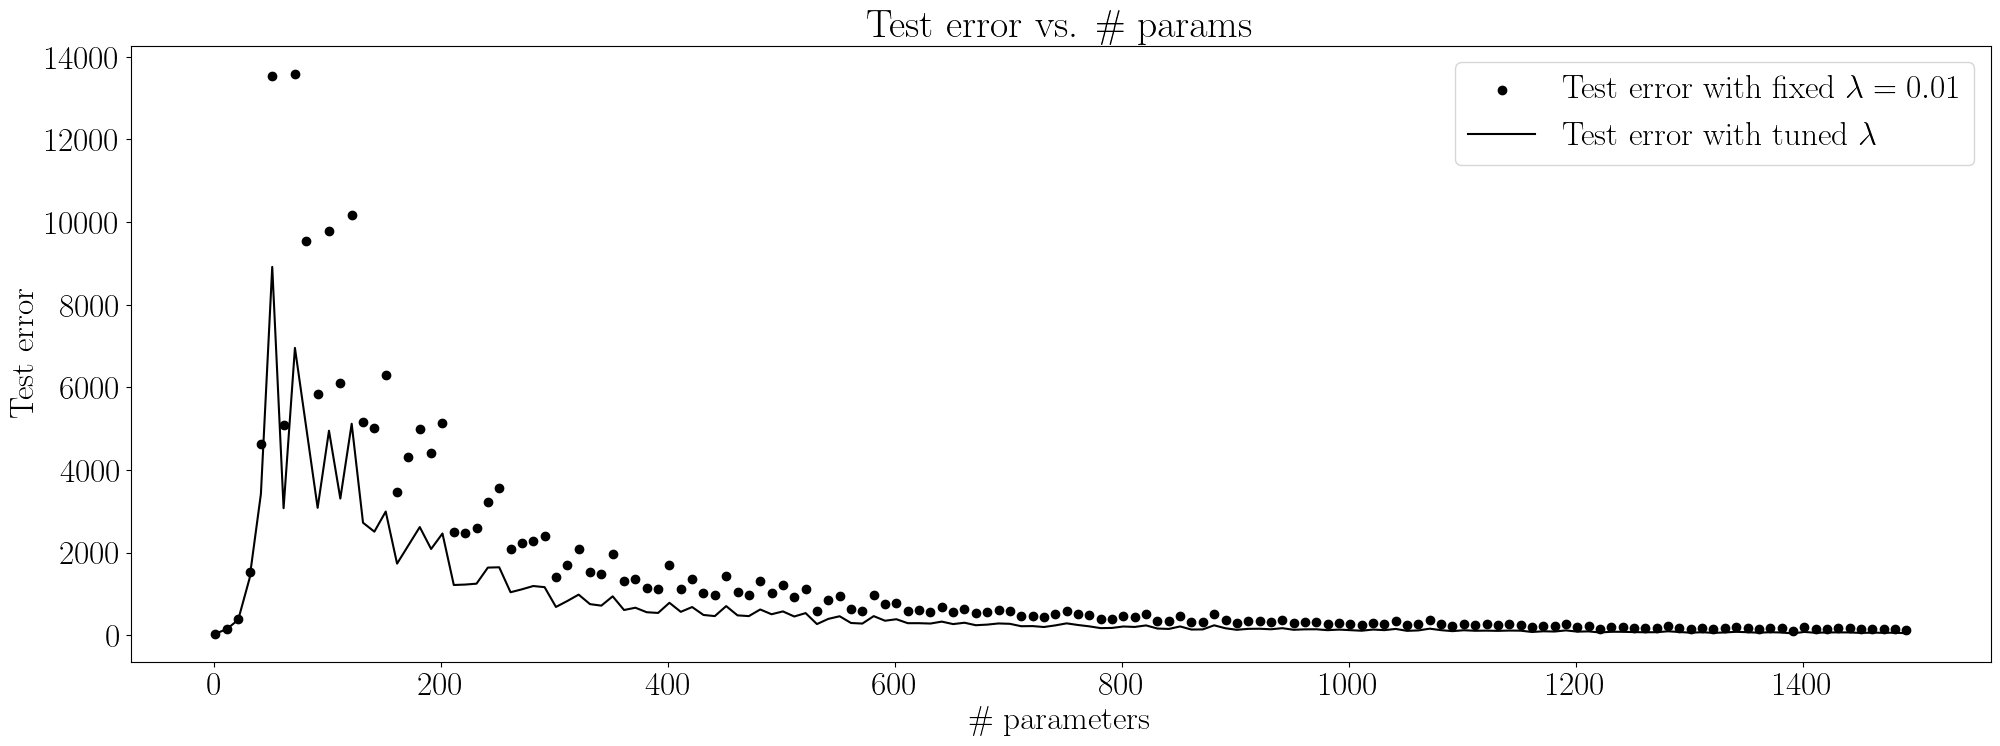

In [7]:
import matplotlib.pyplot as plt 
import numpy as np 


"""
Step 1 : Generate Toy data
"""

d = 35
n_train, n_val, n_test = 300, 60, 30
np.random.seed(0)
beta = np.random.randn(d)
beta_true = beta / np.linalg.norm(beta)
# Generate and fix training data
X_train = np.array([np.random.multivariate_normal(np.zeros(d), np.identity(d)) for _ in range(n_train)])
Y_train = X_train @ beta_true + np.random.normal(loc = 0.0, scale = 0.5, size = n_train)
# Generate and fix validation data (for tuning lambda). 
X_val = np.array([np.random.multivariate_normal(np.zeros(d), np.identity(d)) for _ in range(n_val)])
Y_val = X_val @ beta_true 
# Generate and fix test data
X_test = np.array([np.random.multivariate_normal(np.zeros(d), np.identity(d)) for _ in range(n_test)])
Y_test = X_test @ beta_true 


"""
Step 2 : Solve the problem
"""    
    
lambda_list = [2 ** i for i in range(-6, 6)]
num_params = np.arange(1,1501,10)

errors_opt_lambda = []
errors_fixed_lambda = []
for p in num_params : 
    W = np.random.normal(0, 1/p, (p, d))
    Relu = np.vectorize(lambda z: np.fmax(0,z))
    phi = Relu(X_train @ W.T)
    phi_val = Relu(X_val @ W.T)
    phi_test = Relu(X_test @ W.T)
    phi_gram = phi_val.T @ phi_val
    lambda_opt = min(lambda_list, key = lambda lamb : np.linalg.norm(Y_val - phi_val @ np.linalg.pinv(phi_gram + lamb * np.eye(p)) @ phi_val.T @ Y_val))
    
    theta_fixed = np.linalg.pinv(phi_gram + 0.01 * np.eye(p)) @ phi.T @ Y_train
    theta_opt = np.linalg.pinv(phi_gram + lambda_opt * np.eye(p)) @ phi.T @ Y_train
    
    Y_test_pred_fixed = phi_test @ theta_fixed
    Y_test_pred_opt = phi_test @ theta_opt
    
    errors_fixed_lambda.append(1/2*((Y_test-Y_test_pred_fixed)**2).sum() +0.01/2*np.linalg.norm(theta_fixed))
    errors_opt_lambda.append(1/2*((Y_test-Y_test_pred_opt)**2).sum() + lambda_opt/2*np.linalg.norm(theta_fixed))
"""
Step 3 : Plot the results
"""    

plt.figure(figsize = (24, 8))
plt.rc('text', usetex = True)
plt.rc('font', family = 'serif')
plt.rc('font', size = 24)


plt.scatter(num_params, errors_fixed_lambda, color = 'black',
            label = r"Test error with fixed $\lambda = 0.01$",
            ) 
plt.legend()

plt.plot(num_params, errors_opt_lambda, 'k', label = r"Test error with tuned $\lambda$")
plt.legend()
plt.xlabel(r'$\#$ parameters')
plt.ylabel('Test error')
plt.title(r'Test error vs. $\#$ params')

plt.savefig('double_descent.png')
plt.show()

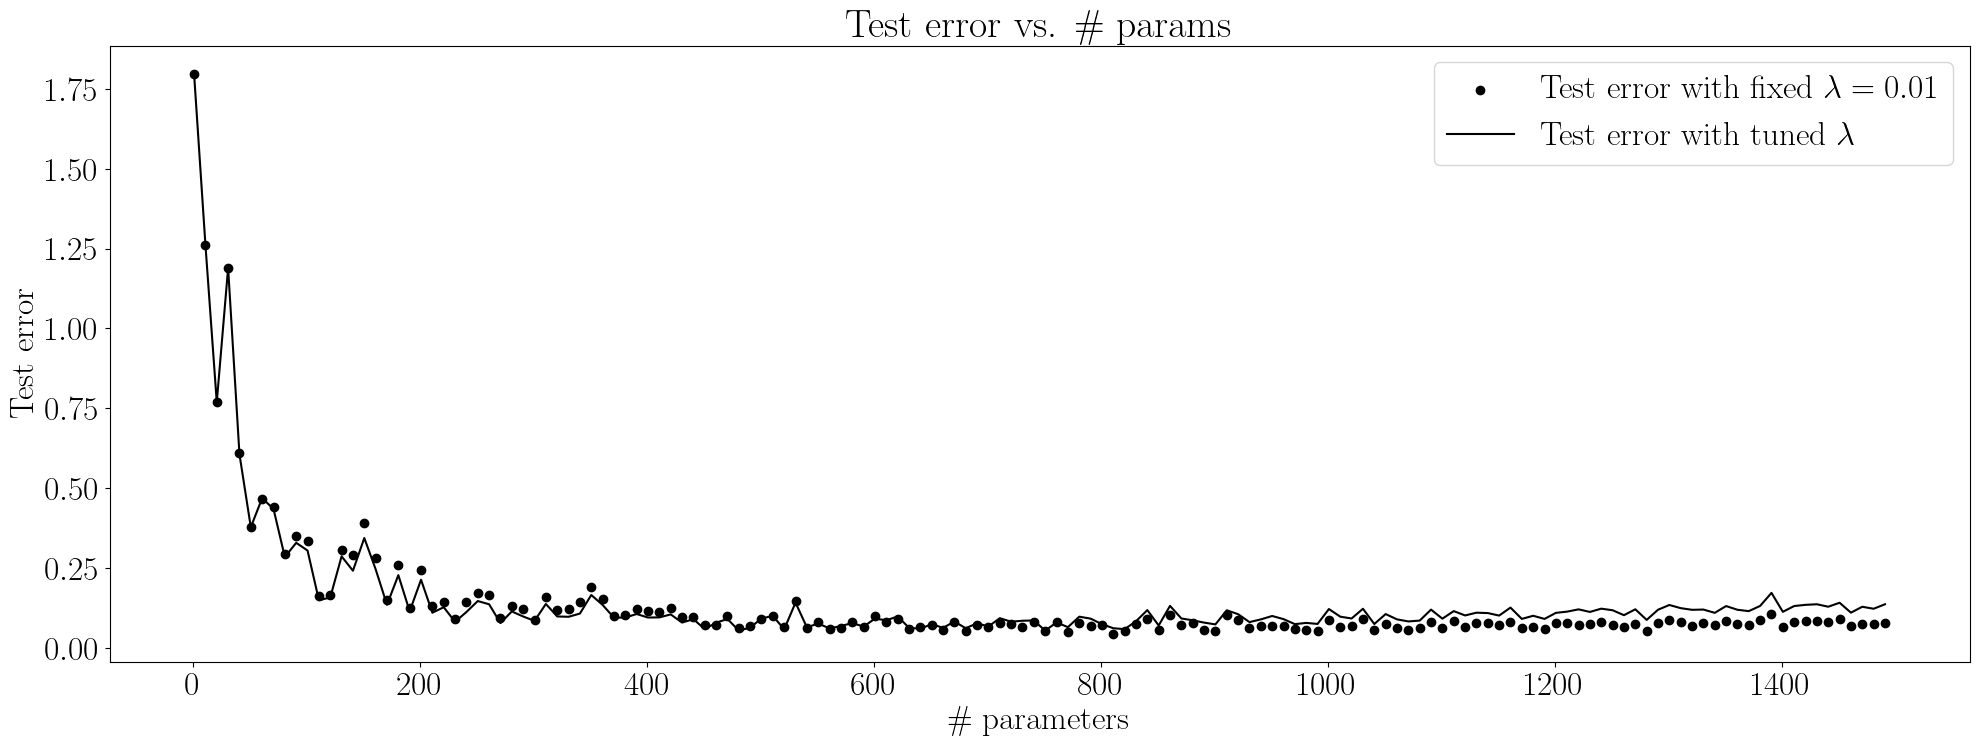

In [2]:
errors_opt_lambda = [1.7977588464318859,
 1.262359825450322,
 0.7688254838591474,
 1.189156884345331,
 0.6058991530969469,
 0.377269855003827,
 0.46820844827298064,
 0.43462040806062097,
 0.2837323917950591,
 0.328393282992772,
 0.3041879031590564,
 0.14868773844737898,
 0.15710058970842633,
 0.2860464012407274,
 0.24088299606785651,
 0.3434174527647808,
 0.24567249293856616,
 0.13432995326322275,
 0.22706615198388386,
 0.11385779482280013,
 0.21274415376433728,
 0.10942835513640876,
 0.1266724703685121,
 0.08085505603954181,
 0.11169565951723139,
 0.1460094159771004,
 0.13584697969101237,
 0.07705125175041753,
 0.11347960505369893,
 0.09760058365861282,
 0.08389786847720042,
 0.13688573816631272,
 0.0977722026835346,
 0.09669002300167585,
 0.10675026086891636,
 0.1649157733477339,
 0.1338864094488597,
 0.09390851173015946,
 0.094283629346967,
 0.10539785725836673,
 0.09438971035998614,
 0.09480971247473627,
 0.10415409997390287,
 0.07852606496757049,
 0.08934933566188183,
 0.058132928393796454,
 0.07806753980450194,
 0.08990052978358117,
 0.05362763542623896,
 0.06250333558784184,
 0.0916470187210975,
 0.09932234038111537,
 0.057557885519332046,
 0.1410771143449783,
 0.0635383738105297,
 0.07572489675550093,
 0.0601084151836878,
 0.06774789054812635,
 0.07703971110099932,
 0.06604128738772708,
 0.0910769274375041,
 0.0856793632652396,
 0.09784598025425353,
 0.062346267007659634,
 0.05906646855958152,
 0.07373847795253455,
 0.0620018750491212,
 0.08173043458192718,
 0.06086426214195091,
 0.07641601516717687,
 0.06629757100283598,
 0.09234710148572238,
 0.08120266120980874,
 0.08433458587840968,
 0.08515572438690325,
 0.05309802435622271,
 0.07915259340878807,
 0.06417239802172102,
 0.09702493258530348,
 0.09091532074968098,
 0.07363213547938983,
 0.0608655964329441,
 0.05788904849843887,
 0.08257645274246077,
 0.11759934941124359,
 0.0694439219771391,
 0.1308839383058618,
 0.09138433854205927,
 0.08568489985549736,
 0.07847487392012735,
 0.07284892866440552,
 0.11706058170277603,
 0.10483509335526629,
 0.08007458875555494,
 0.0885133663161653,
 0.09918258353768117,
 0.08938253662007653,
 0.07363352672186779,
 0.07755182624980116,
 0.0743200564768857,
 0.12098793043664055,
 0.09707597089894106,
 0.09135754822363167,
 0.12186068470465065,
 0.07408334447790713,
 0.10519572543470578,
 0.08863577602640409,
 0.0821561498177512,
 0.08477583700477286,
 0.11914978097030371,
 0.09083820091771787,
 0.1144726584832282,
 0.10088064035330693,
 0.10950927391594752,
 0.10835786858570788,
 0.10045450003551636,
 0.1254854305026577,
 0.09006081544482121,
 0.09985949380373187,
 0.09003594579090718,
 0.10896371443695504,
 0.11289416147617964,
 0.11996572309568182,
 0.11189689677158422,
 0.12212782512024956,
 0.11719158294312719,
 0.10168950595531642,
 0.12015605074406539,
 0.08699279621956608,
 0.11874670589732572,
 0.1336190850818392,
 0.12375859503168331,
 0.11853982983026841,
 0.11933521832182897,
 0.10907117561727538,
 0.13028705718494674,
 0.1186535853875685,
 0.11442969803792666,
 0.1307493271936095,
 0.171530594393455,
 0.11228320692533272,
 0.1304004520797347,
 0.13411118720756468,
 0.13592819532053968,
 0.12821845499823775,
 0.14067031402586513,
 0.10964947209226776,
 0.12811966900676286,
 0.12185564667232106,
 0.1359415191936098]
errors_fixed_lambda = [1.797758774405793,
 1.2622959807777019,
 0.7684912263482795,
 1.1882841963983164,
 0.6091740064708533,
 0.37927833748668793,
 0.4659764198251569,
 0.4398840187756276,
 0.2929682558413536,
 0.3486267680043767,
 0.3336258053915144,
 0.16023959611772512,
 0.16589943825751038,
 0.3069195863758187,
 0.291270913691893,
 0.38927661907738376,
 0.2803164797038855,
 0.14808619920377641,
 0.25835205687234125,
 0.12404220483939937,
 0.24341232851337943,
 0.13061008242962516,
 0.14300377763156547,
 0.08859071377946141,
 0.14311272360419064,
 0.17136935624506008,
 0.16627029455881115,
 0.09368441134753022,
 0.1295765931955241,
 0.12014032556923658,
 0.08640679157989686,
 0.15746503396033593,
 0.11853927150190414,
 0.12107151978230254,
 0.14336923247631145,
 0.19024926004425904,
 0.15284893762684623,
 0.10010060749871776,
 0.10121844270102301,
 0.12131813741536575,
 0.11529177419957894,
 0.1115293499981012,
 0.12538415805316697,
 0.09680691952838147,
 0.09559293112875177,
 0.07181197495083534,
 0.07100092449864673,
 0.0986850468743909,
 0.06222385509413673,
 0.06850161332511662,
 0.09080936647321171,
 0.10024986530676865,
 0.06551189014045349,
 0.14586384656458257,
 0.06008734257671121,
 0.08046444284949399,
 0.05760148690023219,
 0.0600358951891172,
 0.07958809357626927,
 0.06389200691705386,
 0.09840957461279513,
 0.07988014658673127,
 0.09084278021331743,
 0.05780330183265081,
 0.06405007992964279,
 0.07080835065991951,
 0.05662006744406166,
 0.07990979193593571,
 0.05346073927533525,
 0.06943794498381842,
 0.06426249419109979,
 0.07760044740780377,
 0.07348713946663957,
 0.06560775371032282,
 0.07958526534044275,
 0.05172966423578985,
 0.08190393210811373,
 0.0499195011746171,
 0.07800013452358727,
 0.06694911760314645,
 0.07008895070147984,
 0.043779892356390425,
 0.051974534671832856,
 0.07415303856469105,
 0.09055102695701661,
 0.055758114815538246,
 0.10334680691856159,
 0.071120223708858,
 0.0760905192026399,
 0.055372500022964746,
 0.052937244643994026,
 0.10258607816031227,
 0.08766332033705147,
 0.06082594416238068,
 0.06659393792206886,
 0.06924483508410008,
 0.06633520284856702,
 0.05752090310011369,
 0.0555068039033284,
 0.05145147410443001,
 0.08818677095686095,
 0.06541728238631787,
 0.06740810212931757,
 0.08952944399955559,
 0.054571565423534994,
 0.07447723981976336,
 0.061059754386063494,
 0.05483888309355198,
 0.061051854894504584,
 0.08034316349393886,
 0.06244797046416593,
 0.08493753490245289,
 0.06500446749373016,
 0.07872648710940146,
 0.07786304744985637,
 0.07009216691784495,
 0.08175523990037323,
 0.06212245662093128,
 0.06496739444866603,
 0.058463879636677055,
 0.07635935031518776,
 0.07645734215967523,
 0.07245842675189804,
 0.07446028258429897,
 0.07979967744479557,
 0.07138725745787476,
 0.06411575312774918,
 0.07346503429185086,
 0.051459935008898866,
 0.07609079494841642,
 0.08520001546330512,
 0.08070200076770648,
 0.06734915645775134,
 0.07710200703067338,
 0.06966690774864442,
 0.08372127313560966,
 0.07435993806944421,
 0.07077502767318543,
 0.08585528132709816,
 0.10415604922828893,
 0.06607073980201507,
 0.08146149868770307,
 0.08486188995533449,
 0.08464090225548088,
 0.08132793104847767,
 0.0882786843325145,
 0.06627271796415529,
 0.07492010396157393,
 0.07305970039689617,
 0.07828489976697738]

plt.figure(figsize = (24, 8))
plt.rc('text', usetex = True)
plt.rc('font', family = 'serif')
plt.rc('font', size = 24)


plt.scatter(num_params, errors_fixed_lambda, color = 'black',
            label = r"Test error with fixed $\lambda = 0.01$",
            ) 
plt.legend()

plt.plot(num_params, errors_opt_lambda, 'k', label = r"Test error with tuned $\lambda$")
plt.legend()
plt.xlabel(r'$\#$ parameters')
plt.ylabel('Test error')
plt.title(r'Test error vs. $\#$ params')

plt.savefig('double_descent.png')
plt.show()